In [1]:
# ========== IMPORTS ==========

import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Input, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from pathlib import Path
import requests
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import os
import datetime
from numpy.polynomial import Polynomial


2025-04-28 11:46:52.743058: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 11:46:52.773104: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-28 11:46:52.773621: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-28 11:46:53.278139: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
# ========== FOLDER SETUP FOR RESULTS ==========
OUTPUT_DIR_MODELS = "models"
OUTPUT_DIR_PLOTS = "plots"
OUTPUT_DIR_REPORTS = "reports"
OUTPUT_DIR_DEPLOY = "deploy"

os.makedirs(OUTPUT_DIR_MODELS, exist_ok=True)
os.makedirs(OUTPUT_DIR_PLOTS, exist_ok=True)
os.makedirs(OUTPUT_DIR_REPORTS, exist_ok=True)
os.makedirs(OUTPUT_DIR_DEPLOY, exist_ok=True)


In [3]:

# ========== FUNCTIONS ==========
def download_weights(weights_path, root_url):
    p = Path(weights_path)
    if not p.exists():
        print(f"Downloading {weights_path}...")
        p.parent.mkdir(parents=True, exist_ok=True)
        weights_data = requests.get(root_url + weights_path[2:]).content
        with open(weights_path, 'wb') as f:
            f.write(weights_data)
        print("Download complete!")

def load_datasets(pixel_width, batch_size):
    img_size = (pixel_width, pixel_width)
    train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        './data/training',
        labels='inferred',
        label_mode='categorical',
        image_size=img_size,
        batch_size=batch_size,
        validation_split=0.2,
        subset='training',
        seed=42
    )

    validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        './data/training',
        labels='inferred',
        label_mode='categorical',
        image_size=img_size,
        batch_size=batch_size,
        validation_split=0.2,
        subset='validation',
        seed=42
    )

    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        './data/testing',
        labels='inferred',
        label_mode='categorical',
        image_size=img_size,
        batch_size=batch_size,
        shuffle=False
    )

    return train_dataset, validation_dataset, test_dataset

def build_model(input_shape, alpha, num_classes, weights_path, learning_rate):
    base_model = tf.keras.applications.MobileNetV2(
        input_shape=input_shape,
        include_top=False,
        weights=None,
        alpha=alpha
    )
    base_model.load_weights(weights_path, by_name=True, skip_mismatch=True)
    base_model.trainable = False

    inputs = Input(shape=input_shape)
    x = base_model(inputs, training=False)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.1)(x)
    x = Dense(81, activation='relu')(x)
    x = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, x)

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    
    return model, base_model

def representative_data_gen(train_dataset):
    for image, _ in train_dataset.unbatch().take(100):
        yield [tf.expand_dims(tf.cast(image, tf.float32), axis=0)]

def save_as_tflite(model, tflite_filename, train_dataset):
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    converter.optimizations = [tf.lite.Optimize.DEFAULT]
    converter.representative_dataset = lambda: representative_data_gen(train_dataset)
    converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
    converter.inference_input_type = tf.int8
    converter.inference_output_type = tf.int8
    tflite_model = converter.convert()
    with open(tflite_filename, 'wb') as f:
        f.write(tflite_model)

def save_plot(fig, filename):
    fig.savefig(filename)

def evaluate_best_model(best_model, best_base_model, param_grid, timestamp, best_label):
    test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
        './data/testing',
        labels='inferred',
        label_mode='categorical',
        image_size=(param_grid['PIXEL_WIDTH'][0], param_grid['PIXEL_WIDTH'][0]),
        batch_size=param_grid['BATCH_SIZE'][0],
        shuffle=False
    )

    y_true = []
    y_pred = []
    for images, labels_batch in test_dataset:
        preds = best_model.predict(images)
        y_true.extend(np.argmax(labels_batch.numpy(), axis=1))
        y_pred.extend(np.argmax(preds, axis=1))

    class_names = test_dataset.class_names

    report = classification_report(y_true, y_pred, target_names=class_names)
    print("\nClassification Report for Best Model:")
    print(report)
    with open(os.path.join(OUTPUT_DIR_REPORTS, f"classification_report_best_model_{best_label}_{timestamp}.txt"), "w") as f:
        f.write(report)

    cm = confusion_matrix(y_true, y_pred)
    fig = plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix (Best Model: {best_label})')
    plt.tight_layout()
    save_plot(fig, os.path.join(OUTPUT_DIR_PLOTS, f"confusion_matrix_best_model_{best_label}_{timestamp}.png"))

    plt.show()

    print("\n===== Base Model Summary (Best Model) =====")
    best_base_model.summary()

    print("\n===== Full Model Summary (Best Model) =====")
    best_model.summary()
    

def curve_fit_smoothness(values):
    x = np.arange(len(values))
    p = Polynomial.fit(x, values, deg=2)
    fitted = p(x)
    mse = np.mean((values - fitted) ** 2)
    return mse

# 'best' is defined (taking guidance from Brendan's mini project brief) as the smoothest model
# that has good accuracy and loss
def select_best_model(all_histories):
    best_score = -np.inf
    best_idx = 0

    for idx, history in enumerate(all_histories):
        val_acc = np.array(history.history['val_accuracy'])
        val_loss = np.array(history.history['val_loss'])

        avg_acc = np.mean(val_acc[-5:])
        avg_loss = np.mean(val_loss[-5:])

        smoothness_acc = curve_fit_smoothness(val_acc[-5:])
        smoothness_loss = curve_fit_smoothness(val_loss[-5:])

        score = avg_acc - avg_loss - 0.5 * (smoothness_acc + smoothness_loss)

        if score > best_score:
            best_score = score
            best_idx = idx

    return best_idx


In [4]:
# ========== PARAMETER GRID ==========
param_grid = {
    'PIXEL_WIDTH': [96, 128],
    'LEARNING_RATE': [0.001, 0.005, 0.01],
    'ALPHA': [0.1],
    'BATCH_SIZE': [16, 32],
    'EPOCHS': [20]
}

# ========== FIXED CONFIGURATION ==========
NUM_CLASSES = 3
WEIGHTS_PATH = './transfer-learning-weights/edgeimpulse/MobileNetV2.0_1.96x96.color.bsize_64.lr_0_05.epoch_498.val_loss_3.85.hdf5'
root_url = 'https://cdn.edgeimpulse.com/'

# ========== EXECUTION ==========
download_weights(WEIGHTS_PATH, root_url)

timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

all_histories = []
all_models = []
all_base_models = []
labels = []
model_sizes = []
all_train_datasets = []

for pixel_width, lr, alpha, batch_size, epochs in itertools.product(
    param_grid['PIXEL_WIDTH'],
    param_grid['LEARNING_RATE'],
    param_grid['ALPHA'],
    param_grid['BATCH_SIZE'],
    param_grid['EPOCHS']
):
    print(f"Training model with: {pixel_width}px, LR={lr}, alpha={alpha}, batch={batch_size}, epochs={epochs}")

    train_dataset, validation_dataset, test_dataset = load_datasets(pixel_width, batch_size)

    model, base_model = build_model((pixel_width, pixel_width, 3), alpha, NUM_CLASSES, WEIGHTS_PATH, lr)

    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, verbose=2)

    tflite_filename = os.path.join(OUTPUT_DIR_MODELS, f"model_{pixel_width}px_lr{lr}_bs{batch_size}_epochs{epochs}_{timestamp}.tflite")
    save_as_tflite(model, tflite_filename, train_dataset)

    model_size = os.path.getsize(tflite_filename) / 1024  # KB
    print(f"✅ Saved {tflite_filename} ({model_size:.2f} KB)")

    all_histories.append(history)
    all_models.append(model)
    all_base_models.append(base_model)
    labels.append(f"{pixel_width}px_lr{lr}_bs{batch_size}_ep{epochs}")
    model_sizes.append(model_size)
    all_train_datasets.append(train_dataset)


Training model with: 96px, LR=0.001, alpha=0.1, batch=16, epochs=20
Found 470 files belonging to 3 classes.
Using 376 files for training.
Found 470 files belonging to 3 classes.
Using 94 files for validation.
Found 124 files belonging to 3 classes.


2025-04-28 11:46:54.321099: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-28 11:46:54.368436: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/20
24/24 - 9s - loss: 0.9880 - accuracy: 0.6356 - val_loss: 0.4036 - val_accuracy: 0.8404 - 9s/epoch - 392ms/step
Epoch 2/20
24/24 - 8s - loss: 0.2856 - accuracy: 0.8963 - val_loss: 0.1277 - val_accuracy: 0.9681 - 8s/epoch - 313ms/step
Epoch 3/20
24/24 - 7s - loss: 0.2164 - accuracy: 0.9149 - val_loss: 0.1338 - val_accuracy: 0.9468 - 7s/epoch - 288ms/step
Epoch 4/20
24/24 - 7s - loss: 0.1865 - accuracy: 0.9362 - val_loss: 0.1572 - val_accuracy: 0.9362 - 7s/epoch - 287ms/step
Epoch 5/20
24/24 - 7s - loss: 0.1045 - accuracy: 0.9601 - val_loss: 0.1099 - val_accuracy: 0.9787 - 7s/epoch - 284ms/step
Epoch 6/20
24/24 - 7s - loss: 0.2351 - accuracy: 0.9043 - val_loss: 0.1773 - val_accuracy: 0.9255 - 7s/epoch - 298ms/step
Epoch 7/20
24/24 - 7s - loss: 0.1943 - accuracy: 0.9122 - val_loss: 0.1179 - val_accuracy: 0.9468 - 7s/epoch - 290ms/step
Epoch 8/20
24/24 - 7s - loss: 0.1542 - accuracy: 0.9468 - val_loss: 0.1153 - val_accuracy: 0.9574 - 7s/epoch - 297ms/step
Epoch 9/20
24/24 - 7s - 

INFO:tensorflow:Assets written to: /tmp/tmpv1iwsoqn/assets
/home/eamon/anaconda3/envs/tf_hapi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-28 11:49:31.873685: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-28 11:49:31.873724: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-28 11:49:31.874056: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpv1iwsoqn
2025-04-28 11:49:31.894638: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-28 11:49:31.894675: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpv1iwsoqn
2025-04-28 11:49:31.941435: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimiz

✅ Saved models/model_96px_lr0.001_bs16_epochs20_20250428_114654.tflite (319.77 KB)
Training model with: 96px, LR=0.001, alpha=0.1, batch=32, epochs=20
Found 470 files belonging to 3 classes.
Using 376 files for training.
Found 470 files belonging to 3 classes.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Using 94 files for validation.
Found 124 files belonging to 3 classes.
Epoch 1/20
12/12 - 9s - loss: 1.4221 - accuracy: 0.5771 - val_loss: 0.6827 - val_accuracy: 0.7872 - 9s/epoch - 782ms/step
Epoch 2/20
12/12 - 7s - loss: 0.5471 - accuracy: 0.7713 - val_loss: 0.3587 - val_accuracy: 0.8723 - 7s/epoch - 551ms/step
Epoch 3/20
12/12 - 7s - loss: 0.3721 - accuracy: 0.8644 - val_loss: 0.2355 - val_accuracy: 0.8723 - 7s/epoch - 554ms/step
Epoch 4/20
12/12 - 6s - loss: 0.2341 - accuracy: 0.9043 - val_loss: 0.1722 - val_accuracy: 0.9681 - 6s/epoch - 540ms/step
Epoch 5/20
12/12 - 6s - loss: 0.2259 - accuracy: 0.9202 - val_loss: 0.1481 - val_accuracy: 0.9574 - 6s/epoch - 538ms/step
Epoch 6/20
12/12 - 6s - loss: 0.1913 - accuracy: 0.9255 - val_loss: 0.1708 - val_accuracy: 0.9149 - 6s/epoch - 535ms/step
Epoch 7/20
12/12 - 6s - loss: 0.1790 - accuracy: 0.9415 - val_loss: 0.1338 - val_accuracy: 0.9574 - 6s/epoch - 533ms/step
Epoch 8/20
12/12 - 6s - loss: 0.1854 - accuracy: 0.9335 - val_loss: 0.1108 

INFO:tensorflow:Assets written to: /tmp/tmpqg6m0in_/assets
/home/eamon/anaconda3/envs/tf_hapi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-28 11:52:07.297607: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-28 11:52:07.297649: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-28 11:52:07.297922: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpqg6m0in_
2025-04-28 11:52:07.321427: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-28 11:52:07.321457: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpqg6m0in_
2025-04-28 11:52:07.395973: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04

✅ Saved models/model_96px_lr0.001_bs32_epochs20_20250428_114654.tflite (320.48 KB)
Training model with: 96px, LR=0.005, alpha=0.1, batch=16, epochs=20
Found 470 files belonging to 3 classes.
Using 376 files for training.
Found 470 files belonging to 3 classes.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Using 94 files for validation.
Found 124 files belonging to 3 classes.
Epoch 1/20
24/24 - 9s - loss: 2.4474 - accuracy: 0.6250 - val_loss: 0.2626 - val_accuracy: 0.9043 - 9s/epoch - 381ms/step
Epoch 2/20
24/24 - 7s - loss: 0.2296 - accuracy: 0.9176 - val_loss: 0.1487 - val_accuracy: 0.9468 - 7s/epoch - 273ms/step
Epoch 3/20
24/24 - 7s - loss: 0.2592 - accuracy: 0.9016 - val_loss: 0.1699 - val_accuracy: 0.8936 - 7s/epoch - 286ms/step
Epoch 4/20
24/24 - 7s - loss: 0.1782 - accuracy: 0.9309 - val_loss: 0.1416 - val_accuracy: 0.9574 - 7s/epoch - 277ms/step
Epoch 5/20
24/24 - 7s - loss: 0.0830 - accuracy: 0.9761 - val_loss: 0.0874 - val_accuracy: 0.9681 - 7s/epoch - 289ms/step
Epoch 6/20
24/24 - 7s - loss: 0.1350 - accuracy: 0.9441 - val_loss: 0.2531 - val_accuracy: 0.8830 - 7s/epoch - 276ms/step
Epoch 7/20
24/24 - 7s - loss: 0.1154 - accuracy: 0.9521 - val_loss: 0.0968 - val_accuracy: 0.9681 - 7s/epoch - 307ms/step
Epoch 8/20
24/24 - 7s - loss: 0.2854 - accuracy: 0.9069 - val_loss: 0.1728 

INFO:tensorflow:Assets written to: /tmp/tmp21w_qma6/assets
/home/eamon/anaconda3/envs/tf_hapi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-28 11:54:49.807389: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-28 11:54:49.807431: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-28 11:54:49.807616: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp21w_qma6
2025-04-28 11:54:49.826963: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-28 11:54:49.826991: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp21w_qma6
2025-04-28 11:54:49.889679: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04

✅ Saved models/model_96px_lr0.005_bs16_epochs20_20250428_114654.tflite (320.48 KB)
Training model with: 96px, LR=0.005, alpha=0.1, batch=32, epochs=20
Found 470 files belonging to 3 classes.
Using 376 files for training.
Found 470 files belonging to 3 classes.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Using 94 files for validation.
Found 124 files belonging to 3 classes.
Epoch 1/20
12/12 - 9s - loss: 2.6678 - accuracy: 0.5585 - val_loss: 0.6382 - val_accuracy: 0.7340 - 9s/epoch - 757ms/step
Epoch 2/20
12/12 - 7s - loss: 0.4116 - accuracy: 0.8218 - val_loss: 0.2030 - val_accuracy: 0.8936 - 7s/epoch - 606ms/step
Epoch 3/20
12/12 - 7s - loss: 0.2120 - accuracy: 0.9229 - val_loss: 0.1430 - val_accuracy: 0.9681 - 7s/epoch - 588ms/step
Epoch 4/20
12/12 - 7s - loss: 0.2127 - accuracy: 0.9043 - val_loss: 0.0902 - val_accuracy: 0.9787 - 7s/epoch - 571ms/step
Epoch 5/20
12/12 - 7s - loss: 0.1363 - accuracy: 0.9362 - val_loss: 0.1036 - val_accuracy: 0.9574 - 7s/epoch - 554ms/step
Epoch 6/20
12/12 - 7s - loss: 0.1081 - accuracy: 0.9548 - val_loss: 0.1440 - val_accuracy: 0.9362 - 7s/epoch - 569ms/step
Epoch 7/20
12/12 - 7s - loss: 0.1103 - accuracy: 0.9628 - val_loss: 0.2276 - val_accuracy: 0.8723 - 7s/epoch - 566ms/step
Epoch 8/20
12/12 - 7s - loss: 0.1376 - accuracy: 0.9468 - val_loss: 0.2337 

INFO:tensorflow:Assets written to: /tmp/tmpimnst64j/assets
/home/eamon/anaconda3/envs/tf_hapi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-28 11:57:27.341382: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-28 11:57:27.341418: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-28 11:57:27.341592: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpimnst64j
2025-04-28 11:57:27.360211: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-28 11:57:27.360237: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpimnst64j
2025-04-28 11:57:27.421303: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04

✅ Saved models/model_96px_lr0.005_bs32_epochs20_20250428_114654.tflite (320.48 KB)
Training model with: 96px, LR=0.01, alpha=0.1, batch=16, epochs=20
Found 470 files belonging to 3 classes.
Using 376 files for training.
Found 470 files belonging to 3 classes.
Using 94 files for validation.
Found 124 files belonging to 3 classes.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Epoch 1/20
24/24 - 9s - loss: 7.2868 - accuracy: 0.5904 - val_loss: 1.4733 - val_accuracy: 0.7447 - 9s/epoch - 364ms/step
Epoch 2/20
24/24 - 6s - loss: 0.5447 - accuracy: 0.8670 - val_loss: 0.1484 - val_accuracy: 0.9574 - 6s/epoch - 263ms/step
Epoch 3/20
24/24 - 6s - loss: 0.2317 - accuracy: 0.9149 - val_loss: 0.1192 - val_accuracy: 0.9681 - 6s/epoch - 262ms/step
Epoch 4/20
24/24 - 6s - loss: 0.1831 - accuracy: 0.9309 - val_loss: 0.2274 - val_accuracy: 0.9043 - 6s/epoch - 266ms/step
Epoch 5/20
24/24 - 6s - loss: 0.1388 - accuracy: 0.9468 - val_loss: 0.0954 - val_accuracy: 0.9681 - 6s/epoch - 266ms/step
Epoch 6/20
24/24 - 6s - loss: 0.3966 - accuracy: 0.8777 - val_loss: 0.3464 - val_accuracy: 0.9043 - 6s/epoch - 260ms/step
Epoch 7/20
24/24 - 6s - loss: 0.2568 - accuracy: 0.9043 - val_loss: 0.1160 - val_accuracy: 0.9894 - 6s/epoch - 255ms/step
Epoch 8/20
24/24 - 6s - loss: 0.2717 - accuracy: 0.9309 - val_loss: 0.0961 - val_accuracy: 0.9894 - 6s/epoch - 258ms/step
Epoch 9/20
24/24 - 6s - 

INFO:tensorflow:Assets written to: /tmp/tmpgsqoqy5j/assets
/home/eamon/anaconda3/envs/tf_hapi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-28 11:59:54.839329: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-28 11:59:54.839378: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-28 11:59:54.839567: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpgsqoqy5j
2025-04-28 11:59:54.860977: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-28 11:59:54.861006: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpgsqoqy5j
2025-04-28 11:59:54.926514: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04

✅ Saved models/model_96px_lr0.01_bs16_epochs20_20250428_114654.tflite (320.48 KB)
Training model with: 96px, LR=0.01, alpha=0.1, batch=32, epochs=20
Found 470 files belonging to 3 classes.
Using 376 files for training.
Found 470 files belonging to 3 classes.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Using 94 files for validation.
Found 124 files belonging to 3 classes.
Epoch 1/20
12/12 - 8s - loss: 9.0009 - accuracy: 0.3989 - val_loss: 1.1078 - val_accuracy: 0.7234 - 8s/epoch - 692ms/step
Epoch 2/20
12/12 - 6s - loss: 0.8874 - accuracy: 0.6968 - val_loss: 0.7013 - val_accuracy: 0.7766 - 6s/epoch - 517ms/step
Epoch 3/20
12/12 - 6s - loss: 0.6360 - accuracy: 0.7926 - val_loss: 0.6112 - val_accuracy: 0.7340 - 6s/epoch - 511ms/step
Epoch 4/20
12/12 - 6s - loss: 0.5180 - accuracy: 0.7899 - val_loss: 0.3990 - val_accuracy: 0.8511 - 6s/epoch - 520ms/step
Epoch 5/20
12/12 - 6s - loss: 0.3616 - accuracy: 0.8644 - val_loss: 0.3343 - val_accuracy: 0.8723 - 6s/epoch - 515ms/step
Epoch 6/20
12/12 - 6s - loss: 0.2846 - accuracy: 0.8803 - val_loss: 0.3122 - val_accuracy: 0.8723 - 6s/epoch - 515ms/step
Epoch 7/20
12/12 - 6s - loss: 0.2895 - accuracy: 0.9016 - val_loss: 0.2952 - val_accuracy: 0.8830 - 6s/epoch - 515ms/step
Epoch 8/20
12/12 - 6s - loss: 0.2224 - accuracy: 0.9255 - val_loss: 0.2146 

INFO:tensorflow:Assets written to: /tmp/tmpkug38f_k/assets
/home/eamon/anaconda3/envs/tf_hapi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-28 12:02:21.693370: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-28 12:02:21.693404: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-28 12:02:21.693567: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkug38f_k
2025-04-28 12:02:21.712826: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-28 12:02:21.712850: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpkug38f_k
2025-04-28 12:02:21.772547: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04

✅ Saved models/model_96px_lr0.01_bs32_epochs20_20250428_114654.tflite (320.49 KB)
Training model with: 128px, LR=0.001, alpha=0.1, batch=16, epochs=20
Found 470 files belonging to 3 classes.
Using 376 files for training.
Found 470 files belonging to 3 classes.
Using 94 files for validation.
Found 124 files belonging to 3 classes.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Epoch 1/20
24/24 - 8s - loss: 1.0177 - accuracy: 0.6011 - val_loss: 0.5754 - val_accuracy: 0.7979 - 8s/epoch - 353ms/step
Epoch 2/20
24/24 - 7s - loss: 0.5445 - accuracy: 0.7899 - val_loss: 0.4188 - val_accuracy: 0.8298 - 7s/epoch - 272ms/step
Epoch 3/20
24/24 - 7s - loss: 0.4547 - accuracy: 0.8005 - val_loss: 0.3470 - val_accuracy: 0.8511 - 7s/epoch - 272ms/step
Epoch 4/20
24/24 - 7s - loss: 0.3521 - accuracy: 0.8590 - val_loss: 0.2203 - val_accuracy: 0.9468 - 7s/epoch - 278ms/step
Epoch 5/20
24/24 - 7s - loss: 0.2711 - accuracy: 0.8936 - val_loss: 0.2064 - val_accuracy: 0.9468 - 7s/epoch - 278ms/step
Epoch 6/20
24/24 - 7s - loss: 0.2345 - accuracy: 0.9309 - val_loss: 0.1756 - val_accuracy: 0.9681 - 7s/epoch - 275ms/step
Epoch 7/20
24/24 - 7s - loss: 0.2113 - accuracy: 0.9229 - val_loss: 0.1516 - val_accuracy: 0.9681 - 7s/epoch - 293ms/step
Epoch 8/20
24/24 - 6s - loss: 0.2388 - accuracy: 0.9149 - val_loss: 0.1559 - val_accuracy: 0.9681 - 6s/epoch - 270ms/step
Epoch 9/20
24/24 - 6s - 

INFO:tensorflow:Assets written to: /tmp/tmpcsdgdclc/assets
/home/eamon/anaconda3/envs/tf_hapi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-28 12:04:54.723757: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-28 12:04:54.723793: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-28 12:04:54.723967: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpcsdgdclc
2025-04-28 12:04:54.749834: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-28 12:04:54.749860: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpcsdgdclc
2025-04-28 12:04:54.814484: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04

✅ Saved models/model_128px_lr0.001_bs16_epochs20_20250428_114654.tflite (320.76 KB)
Training model with: 128px, LR=0.001, alpha=0.1, batch=32, epochs=20
Found 470 files belonging to 3 classes.
Using 376 files for training.
Found 470 files belonging to 3 classes.
Using 94 files for validation.
Found 124 files belonging to 3 classes.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Epoch 1/20
12/12 - 8s - loss: 2.0742 - accuracy: 0.4176 - val_loss: 0.8797 - val_accuracy: 0.5851 - 8s/epoch - 703ms/step
Epoch 2/20
12/12 - 6s - loss: 0.9052 - accuracy: 0.5691 - val_loss: 0.6755 - val_accuracy: 0.6809 - 6s/epoch - 529ms/step
Epoch 3/20
12/12 - 6s - loss: 0.6189 - accuracy: 0.7367 - val_loss: 0.4914 - val_accuracy: 0.8191 - 6s/epoch - 535ms/step
Epoch 4/20
12/12 - 6s - loss: 0.4790 - accuracy: 0.8165 - val_loss: 0.4028 - val_accuracy: 0.8723 - 6s/epoch - 533ms/step
Epoch 5/20
12/12 - 6s - loss: 0.4428 - accuracy: 0.8298 - val_loss: 0.3686 - val_accuracy: 0.8617 - 6s/epoch - 528ms/step
Epoch 6/20
12/12 - 6s - loss: 0.3769 - accuracy: 0.8777 - val_loss: 0.3729 - val_accuracy: 0.7979 - 6s/epoch - 534ms/step
Epoch 7/20
12/12 - 6s - loss: 0.3835 - accuracy: 0.8644 - val_loss: 0.3174 - val_accuracy: 0.8617 - 6s/epoch - 529ms/step
Epoch 8/20
12/12 - 6s - loss: 0.3225 - accuracy: 0.8883 - val_loss: 0.2693 - val_accuracy: 0.9255 - 6s/epoch - 529ms/step
Epoch 9/20
12/12 - 6s - 

INFO:tensorflow:Assets written to: /tmp/tmp4g2t35rr/assets
/home/eamon/anaconda3/envs/tf_hapi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-28 12:07:24.728201: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-28 12:07:24.728234: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-28 12:07:24.728410: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp4g2t35rr
2025-04-28 12:07:24.755209: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-28 12:07:24.755236: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp4g2t35rr
2025-04-28 12:07:24.823388: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04

✅ Saved models/model_128px_lr0.001_bs32_epochs20_20250428_114654.tflite (320.76 KB)
Training model with: 128px, LR=0.005, alpha=0.1, batch=16, epochs=20
Found 470 files belonging to 3 classes.
Using 376 files for training.
Found 470 files belonging to 3 classes.
Using 94 files for validation.
Found 124 files belonging to 3 classes.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Epoch 1/20
24/24 - 8s - loss: 3.2892 - accuracy: 0.5532 - val_loss: 1.0060 - val_accuracy: 0.6596 - 8s/epoch - 349ms/step
Epoch 2/20
24/24 - 7s - loss: 0.4936 - accuracy: 0.8005 - val_loss: 0.2335 - val_accuracy: 0.9255 - 7s/epoch - 271ms/step
Epoch 3/20
24/24 - 6s - loss: 0.3920 - accuracy: 0.8457 - val_loss: 0.5952 - val_accuracy: 0.7128 - 6s/epoch - 269ms/step
Epoch 4/20
24/24 - 6s - loss: 0.3824 - accuracy: 0.8590 - val_loss: 0.2376 - val_accuracy: 0.8723 - 6s/epoch - 268ms/step
Epoch 5/20
24/24 - 7s - loss: 0.1987 - accuracy: 0.9309 - val_loss: 0.2016 - val_accuracy: 0.8936 - 7s/epoch - 281ms/step
Epoch 6/20
24/24 - 6s - loss: 0.5359 - accuracy: 0.8112 - val_loss: 0.5784 - val_accuracy: 0.8191 - 6s/epoch - 269ms/step
Epoch 7/20
24/24 - 7s - loss: 0.1855 - accuracy: 0.9282 - val_loss: 0.1138 - val_accuracy: 0.9787 - 7s/epoch - 273ms/step
Epoch 8/20
24/24 - 6s - loss: 0.1572 - accuracy: 0.9468 - val_loss: 0.1126 - val_accuracy: 0.9681 - 6s/epoch - 267ms/step
Epoch 9/20
24/24 - 6s - 

INFO:tensorflow:Assets written to: /tmp/tmptm4s2566/assets
/home/eamon/anaconda3/envs/tf_hapi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-28 12:09:56.066477: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-28 12:09:56.066509: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-28 12:09:56.066671: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmptm4s2566
2025-04-28 12:09:56.084621: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-28 12:09:56.084648: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmptm4s2566
2025-04-28 12:09:56.144941: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04

✅ Saved models/model_128px_lr0.005_bs16_epochs20_20250428_114654.tflite (320.76 KB)
Training model with: 128px, LR=0.005, alpha=0.1, batch=32, epochs=20
Found 470 files belonging to 3 classes.
Using 376 files for training.
Found 470 files belonging to 3 classes.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Using 94 files for validation.
Found 124 files belonging to 3 classes.
Epoch 1/20
12/12 - 8s - loss: 5.2319 - accuracy: 0.3697 - val_loss: 1.9635 - val_accuracy: 0.5638 - 8s/epoch - 696ms/step
Epoch 2/20
12/12 - 6s - loss: 1.7028 - accuracy: 0.5532 - val_loss: 1.0591 - val_accuracy: 0.6064 - 6s/epoch - 535ms/step
Epoch 3/20
12/12 - 7s - loss: 0.6368 - accuracy: 0.7553 - val_loss: 0.4806 - val_accuracy: 0.7766 - 7s/epoch - 542ms/step
Epoch 4/20
12/12 - 7s - loss: 0.3994 - accuracy: 0.8590 - val_loss: 0.3481 - val_accuracy: 0.8191 - 7s/epoch - 542ms/step
Epoch 5/20
12/12 - 6s - loss: 0.3569 - accuracy: 0.8484 - val_loss: 0.2698 - val_accuracy: 0.8936 - 6s/epoch - 539ms/step
Epoch 6/20
12/12 - 6s - loss: 0.2342 - accuracy: 0.9415 - val_loss: 0.2616 - val_accuracy: 0.8830 - 6s/epoch - 537ms/step
Epoch 7/20
12/12 - 6s - loss: 0.2182 - accuracy: 0.9335 - val_loss: 0.2321 - val_accuracy: 0.9149 - 6s/epoch - 525ms/step
Epoch 8/20
12/12 - 6s - loss: 0.1960 - accuracy: 0.9362 - val_loss: 0.2049 

INFO:tensorflow:Assets written to: /tmp/tmpw62bh187/assets
/home/eamon/anaconda3/envs/tf_hapi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-28 12:12:26.773504: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-28 12:12:26.773536: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-28 12:12:26.773702: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpw62bh187
2025-04-28 12:12:26.792110: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-28 12:12:26.792133: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpw62bh187
2025-04-28 12:12:26.851207: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04

✅ Saved models/model_128px_lr0.005_bs32_epochs20_20250428_114654.tflite (320.76 KB)
Training model with: 128px, LR=0.01, alpha=0.1, batch=16, epochs=20
Found 470 files belonging to 3 classes.
Using 376 files for training.
Found 470 files belonging to 3 classes.
Using 94 files for validation.
Found 124 files belonging to 3 classes.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Epoch 1/20
24/24 - 9s - loss: 9.4124 - accuracy: 0.4255 - val_loss: 1.3672 - val_accuracy: 0.2234 - 9s/epoch - 355ms/step
Epoch 2/20
24/24 - 6s - loss: 1.0764 - accuracy: 0.4707 - val_loss: 1.1065 - val_accuracy: 0.2234 - 6s/epoch - 269ms/step
Epoch 3/20
24/24 - 6s - loss: 1.0962 - accuracy: 0.3963 - val_loss: 1.0816 - val_accuracy: 0.5426 - 6s/epoch - 269ms/step
Epoch 4/20
24/24 - 6s - loss: 1.0707 - accuracy: 0.4973 - val_loss: 1.0502 - val_accuracy: 0.5426 - 6s/epoch - 269ms/step
Epoch 5/20
24/24 - 7s - loss: 1.0536 - accuracy: 0.4973 - val_loss: 1.0321 - val_accuracy: 0.5426 - 7s/epoch - 273ms/step
Epoch 6/20
24/24 - 6s - loss: 1.0459 - accuracy: 0.4973 - val_loss: 1.0232 - val_accuracy: 0.5426 - 6s/epoch - 264ms/step
Epoch 7/20
24/24 - 6s - loss: 1.0872 - accuracy: 0.4973 - val_loss: 1.0195 - val_accuracy: 0.5426 - 6s/epoch - 268ms/step
Epoch 8/20
24/24 - 6s - loss: 1.0415 - accuracy: 0.4973 - val_loss: 1.0173 - val_accuracy: 0.5426 - 6s/epoch - 268ms/step
Epoch 9/20
24/24 - 6s - 

INFO:tensorflow:Assets written to: /tmp/tmp9tvqavur/assets
/home/eamon/anaconda3/envs/tf_hapi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-28 12:14:58.256693: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-28 12:14:58.256728: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-28 12:14:58.256901: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp9tvqavur
2025-04-28 12:14:58.276438: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-28 12:14:58.276464: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp9tvqavur
2025-04-28 12:14:58.339567: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04

✅ Saved models/model_128px_lr0.01_bs16_epochs20_20250428_114654.tflite (321.17 KB)
Training model with: 128px, LR=0.01, alpha=0.1, batch=32, epochs=20
Found 470 files belonging to 3 classes.
Using 376 files for training.
Found 470 files belonging to 3 classes.


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


Using 94 files for validation.
Found 124 files belonging to 3 classes.
Epoch 1/20
12/12 - 8s - loss: 13.5995 - accuracy: 0.4388 - val_loss: 1.3144 - val_accuracy: 0.5532 - 8s/epoch - 696ms/step
Epoch 2/20
12/12 - 6s - loss: 1.2282 - accuracy: 0.4495 - val_loss: 0.8760 - val_accuracy: 0.5532 - 6s/epoch - 530ms/step
Epoch 3/20
12/12 - 6s - loss: 0.7689 - accuracy: 0.6170 - val_loss: 0.6563 - val_accuracy: 0.7234 - 6s/epoch - 535ms/step
Epoch 4/20
12/12 - 6s - loss: 0.6164 - accuracy: 0.7048 - val_loss: 0.5226 - val_accuracy: 0.7234 - 6s/epoch - 529ms/step
Epoch 5/20
12/12 - 6s - loss: 0.5374 - accuracy: 0.7287 - val_loss: 0.4813 - val_accuracy: 0.7447 - 6s/epoch - 533ms/step
Epoch 6/20
12/12 - 6s - loss: 0.4913 - accuracy: 0.7527 - val_loss: 0.4624 - val_accuracy: 0.7447 - 6s/epoch - 528ms/step
Epoch 7/20
12/12 - 6s - loss: 0.4913 - accuracy: 0.7420 - val_loss: 0.4260 - val_accuracy: 0.7553 - 6s/epoch - 539ms/step
Epoch 8/20
12/12 - 6s - loss: 0.4252 - accuracy: 0.7606 - val_loss: 0.4084

INFO:tensorflow:Assets written to: /tmp/tmp2wxgicc9/assets
/home/eamon/anaconda3/envs/tf_hapi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-28 12:17:28.126690: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-28 12:17:28.126727: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-28 12:17:28.126906: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp2wxgicc9
2025-04-28 12:17:28.153506: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-28 12:17:28.153536: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp2wxgicc9
2025-04-28 12:17:28.222141: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04

✅ Saved models/model_128px_lr0.01_bs32_epochs20_20250428_114654.tflite (321.17 KB)


fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8


96px_lr0.001_bs16_ep20: 319.77 KB
96px_lr0.001_bs32_ep20: 320.48 KB
96px_lr0.005_bs16_ep20: 320.48 KB
96px_lr0.005_bs32_ep20: 320.48 KB
96px_lr0.01_bs16_ep20: 320.48 KB
96px_lr0.01_bs32_ep20: 320.49 KB
128px_lr0.001_bs16_ep20: 320.76 KB
128px_lr0.001_bs32_ep20: 320.76 KB
128px_lr0.005_bs16_ep20: 320.76 KB
128px_lr0.005_bs32_ep20: 320.76 KB
128px_lr0.01_bs16_ep20: 321.17 KB
128px_lr0.01_bs32_ep20: 321.17 KB
INFO:tensorflow:Assets written to: /tmp/tmpkjhws7q2/assets


INFO:tensorflow:Assets written to: /tmp/tmpkjhws7q2/assets
/home/eamon/anaconda3/envs/tf_hapi/lib/python3.10/site-packages/tensorflow/lite/python/convert.py:887: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
2025-04-28 12:17:48.755359: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-28 12:17:48.755398: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-28 12:17:48.755580: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmpkjhws7q2
2025-04-28 12:17:48.772267: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-28 12:17:48.772293: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmpkjhws7q2
2025-04-28 12:17:48.835076: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04

✅ Best model saved for deployment: deploy/trained.tflite
✅ Class labels saved: deploy/labels.txt


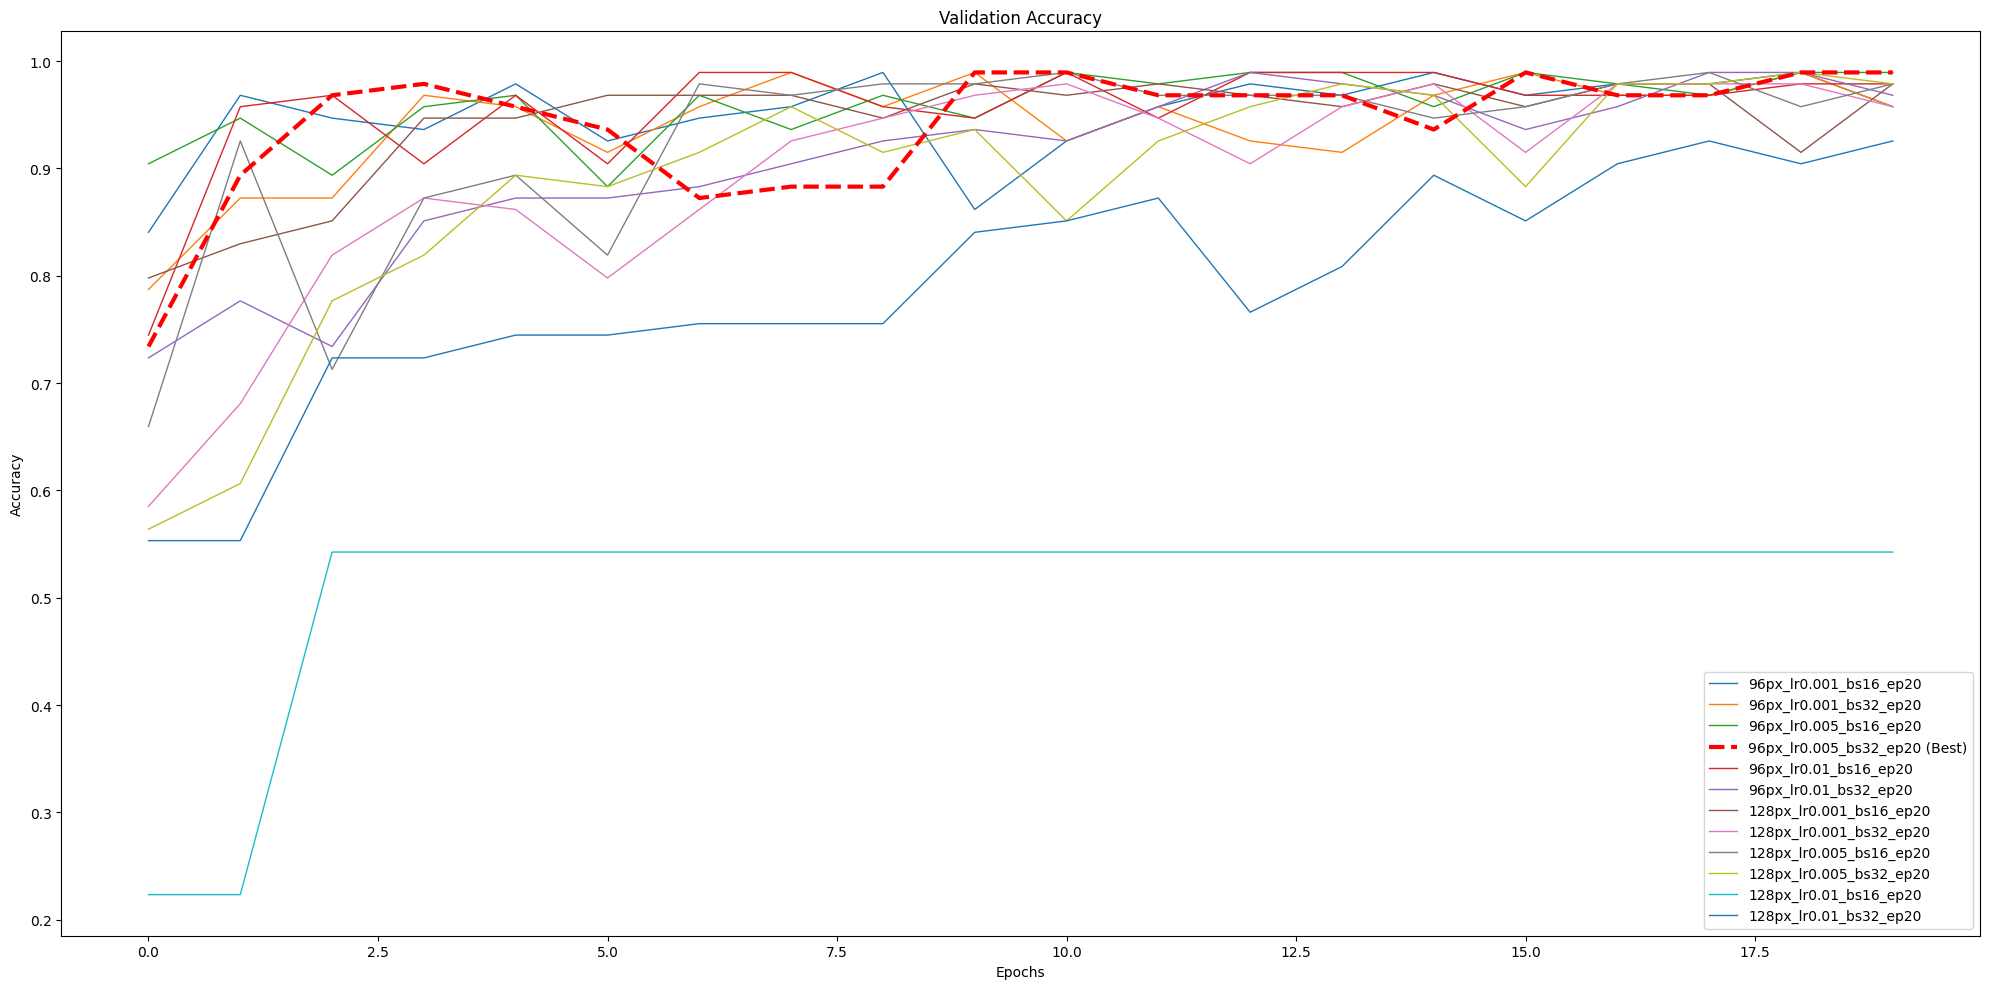

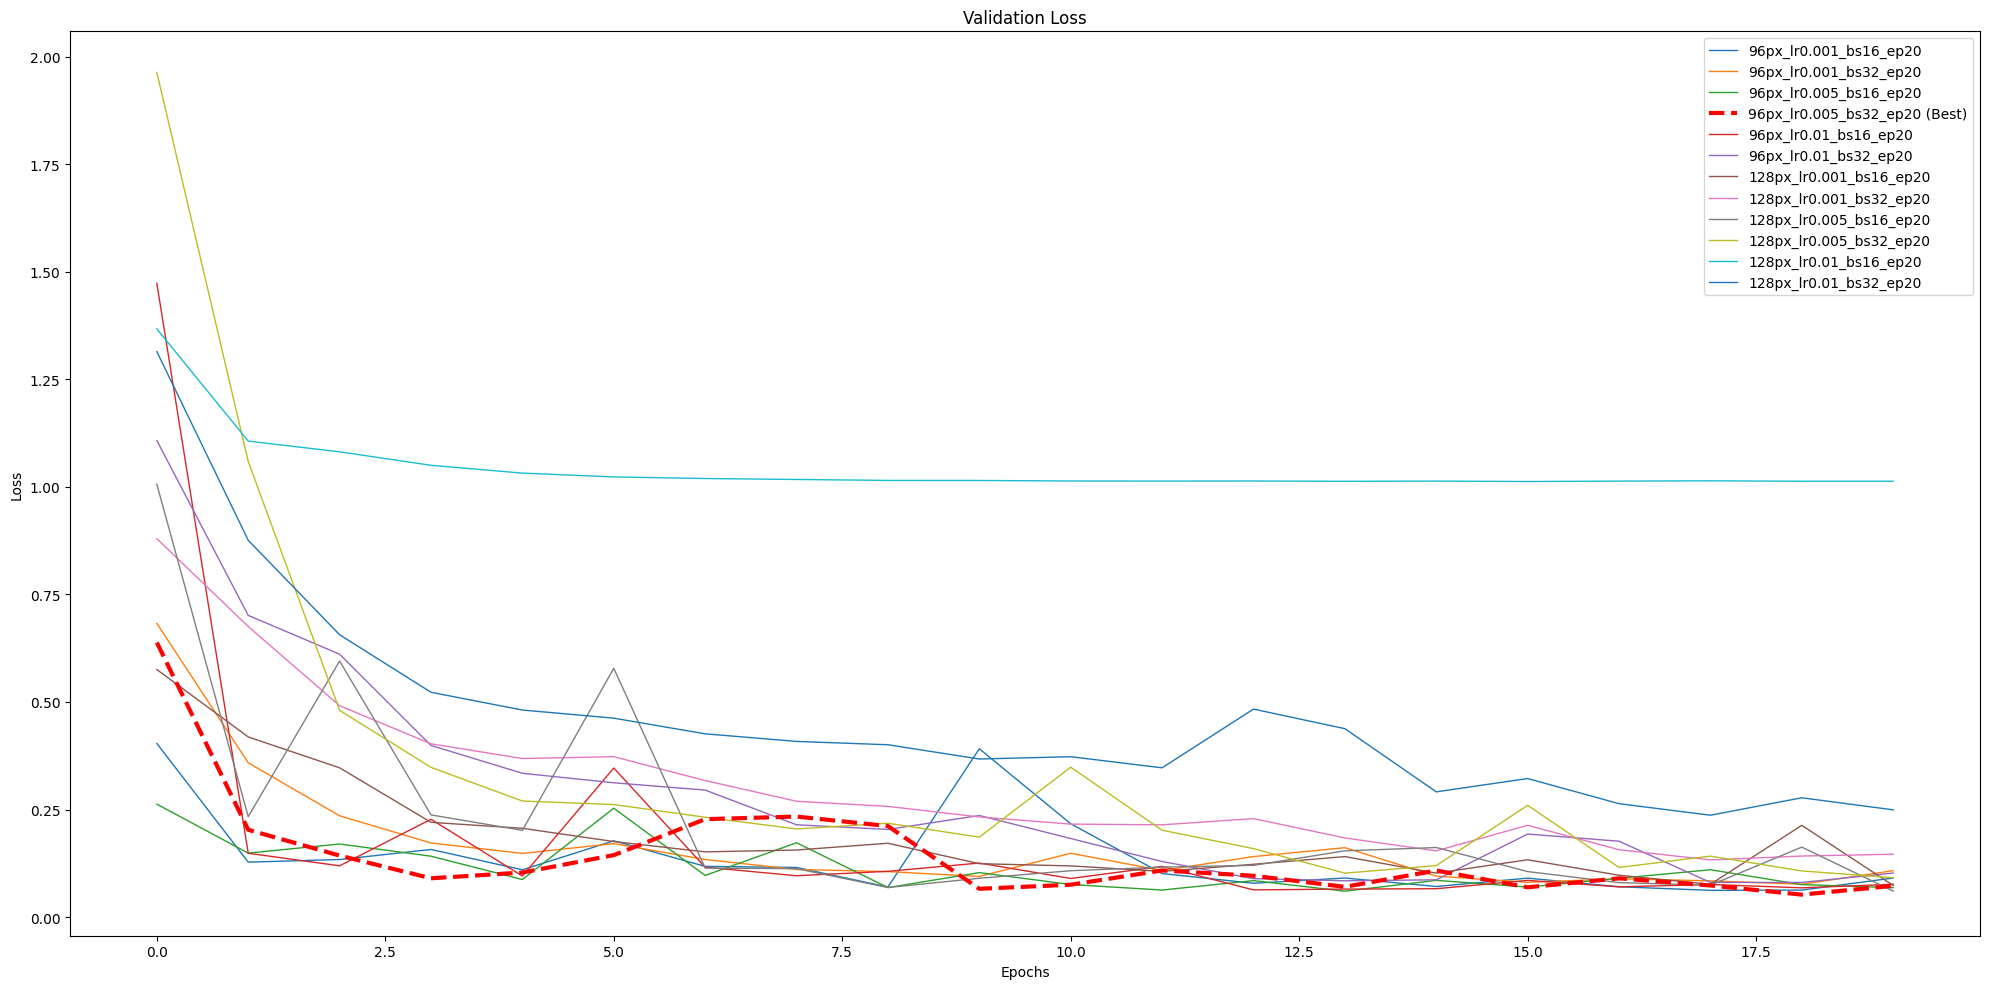

In [5]:
# Print model sizes
for label, size in zip(labels, model_sizes):
    print(f"{label}: {size:.2f} KB")
    
# ========== SELECT BEST MODEL ==========
best_idx = select_best_model(all_histories)
best_model = all_models[best_idx]
best_base_model = all_base_models[best_idx]
trained_tflite_path = os.path.join(OUTPUT_DIR_DEPLOY, "trained.tflite")
save_as_tflite(best_model, trained_tflite_path, all_train_datasets[best_idx])


print(f"✅ Best model saved for deployment: {trained_tflite_path}")
labels_txt_path = os.path.join(OUTPUT_DIR_DEPLOY, "labels.txt")
with open(labels_txt_path, "w") as f:
    f.write("\n".join(test_dataset.class_names))
print(f"✅ Class labels saved: {labels_txt_path}")



# ========== PLOTTING ==========
fig1 = plt.figure(figsize=(20, 10))
for idx, (history, label) in enumerate(zip(all_histories, labels)):
    if idx == best_idx:
        plt.plot(history.history['val_accuracy'], label=f"{label} (Best)", 
                 linewidth=3, linestyle='--', color='red', zorder=10)
    else:
        plt.plot(history.history['val_accuracy'], label=label, linewidth=1, zorder=1)

plt.title('Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
save_plot(fig1, os.path.join(OUTPUT_DIR_PLOTS, f"validation_accuracy_plot_{timestamp}.png"))
plt.show()

fig2 = plt.figure(figsize=(20, 10))
for idx, (history, label) in enumerate(zip(all_histories, labels)):
    if idx == best_idx:
        plt.plot(history.history['val_loss'], label=f"{label} (Best)", 
                 linewidth=3, linestyle='--', color='red', zorder=10)
    else:
        plt.plot(history.history['val_loss'], label=label, linewidth=1, zorder=1)

plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='best', fontsize=10)
plt.tight_layout()
save_plot(fig2, os.path.join(OUTPUT_DIR_PLOTS, f"validation_loss_plot_{timestamp}.png"))
plt.show()




Found 124 files belonging to 3 classes.
1/1 [==============================] - 0s 37ms/step

Classification Report for Best Model:
              precision    recall  f1-score   support

  ThumbsDown       0.97      0.94      0.96        34
    ThumbsUp       0.84      1.00      0.91        32
     Unknown       1.00      0.91      0.95        58

    accuracy                           0.94       124
   macro avg       0.94      0.95      0.94       124
weighted avg       0.95      0.94      0.94       124



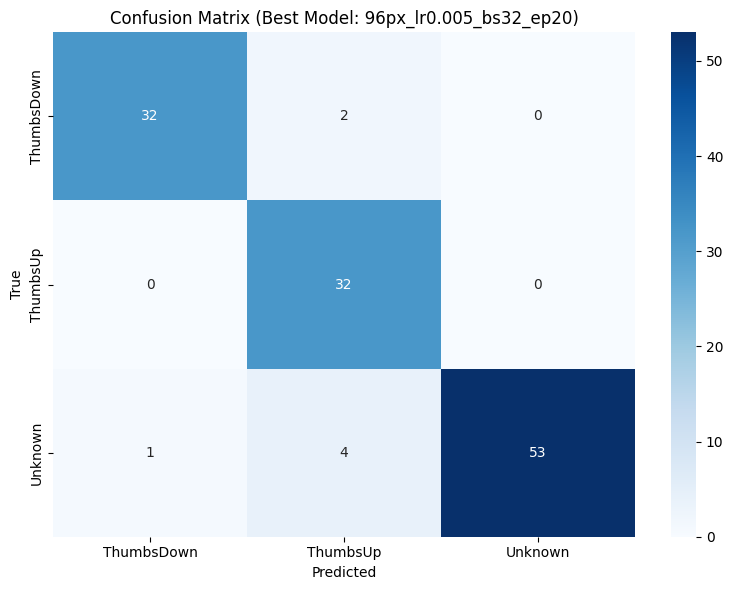


===== Base Model Summary (Best Model) =====
Model: "mobilenetv2_0.10_96"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 48, 48, 8)            216       ['input_7[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 48, 48, 8)            32        ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None,

In [6]:
# ========== EVALUATE BEST MODEL ==========
evaluate_best_model(best_model, best_base_model, param_grid, timestamp, best_label=labels[best_idx])